In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Paths and stuff
import os
import sys

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
surfvel_data_40kms = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/surfvel_data_40kms.nc")
vs_uncert_data = surfvel_data_40kms["vs_uncert"].data

In [3]:
sicopolis_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS'
simulation = 'grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp'
dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(12, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1

log_c_slide_init = np.log10(13.5)*np.ones((JMAX+1, IMAX+1))

# Ensure the sequence in these arrays is the same as defined in ad_specs.h
dict_og_params_fields_vals = {"xx_c_slide_init": log_c_slide_init}
dict_params_fields_num_dims = {"xx_c_slide_init": "2D"}
dict_params_coords = {"time_ad": time_ad,
               "zeta_c": exp_sigma_level,
               "y": yModel40,
               "x": xModel40}
dict_params_attrs_type = {"xx_c_slide_init": "nodiff"}
dict_params_fields_or_scalars = {"xx_c_slide_init": "field"}
dict_masks_observables = {"vs": vs_uncert_data**(-2)}

dict_prior_sigmas = {"xx_c_slide_init": 1.0}
dict_prior_gammas = {"xx_c_slide_init": 1.0}
dict_prior_deltas = {"xx_c_slide_init": 1.e-3}

MAX_ITERS_SOR = 100
OMEGA_SOR = 1.5

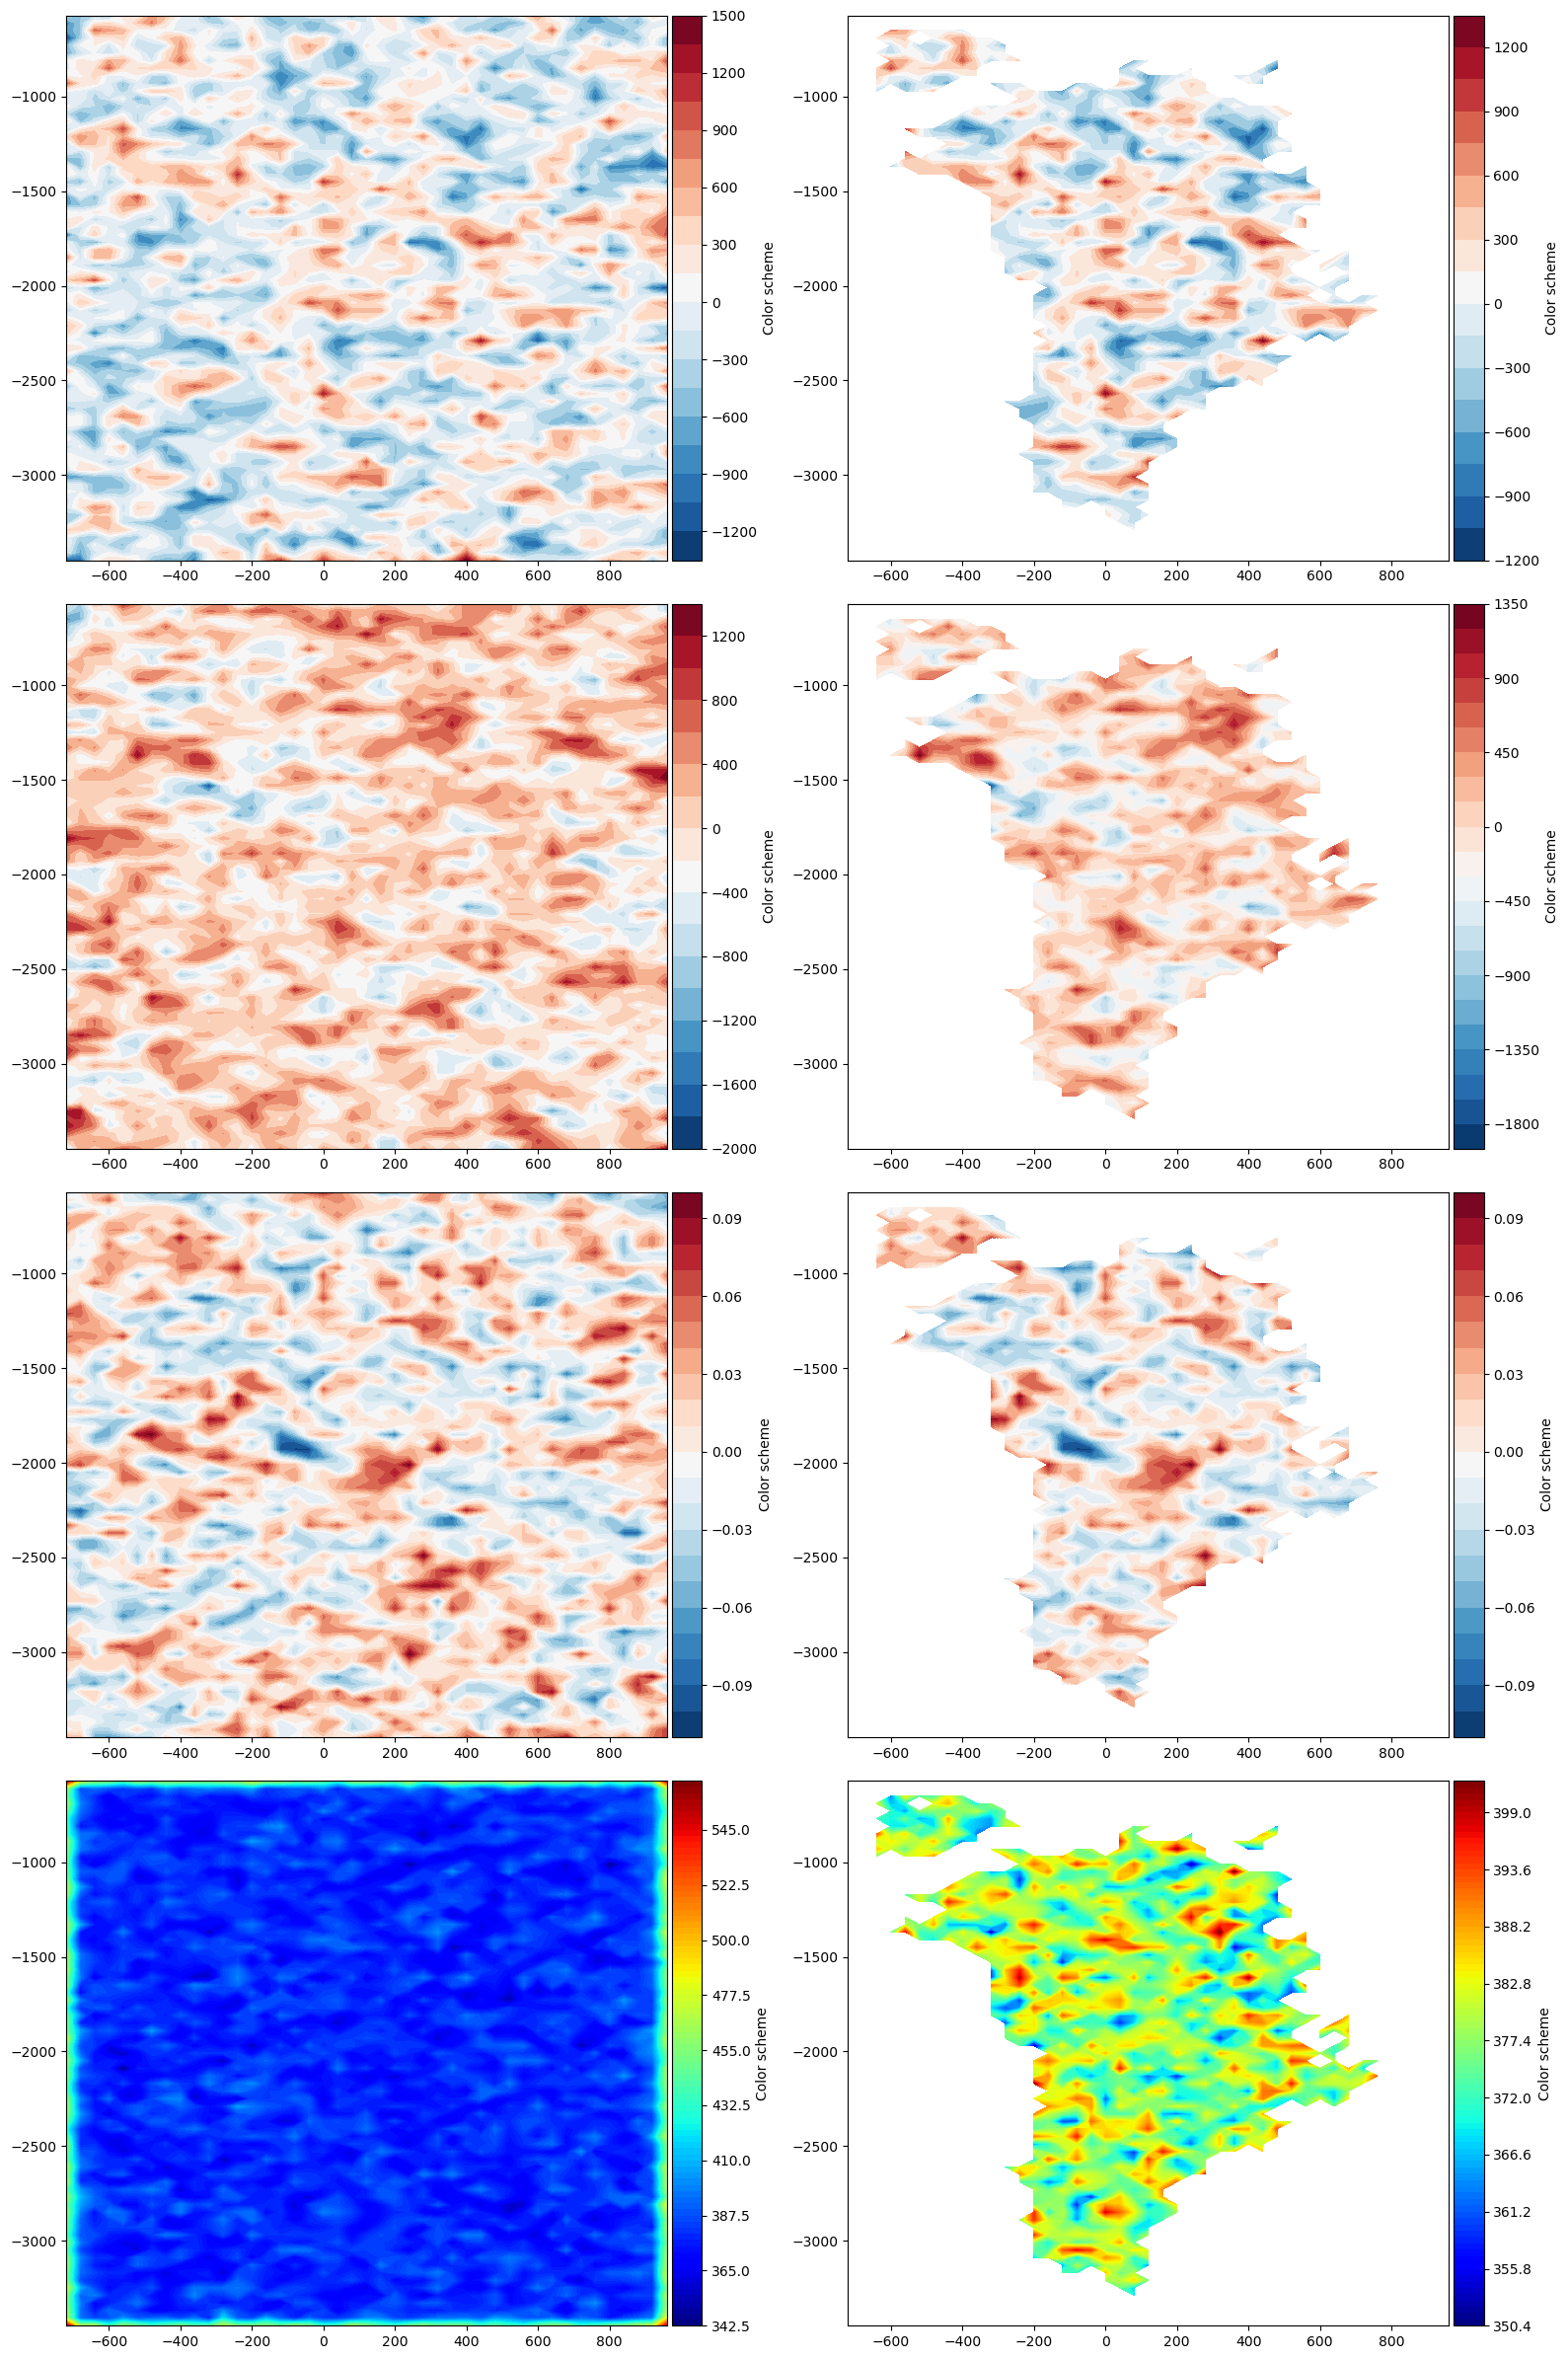

In [4]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir", 1000, None)

ds_prior_X = DA.ds_prior_X.copy()

ds_subset_sample_prior_C_1 = DA.sample_prior_C()
ds_subset_sample_prior_C_2 = DA.sample_prior_C()
ds_mean_samples_prior_C, ds_std_samples_prior_C = DA.ds_prior_C_mean, DA.ds_prior_C_std

ds_subset_sample_prior_1 = DA.sample_prior()
ds_subset_sample_prior_2 = DA.sample_prior()
ds_mean_samples_prior, ds_std_samples_prior = DA.pointwise_marginals("prior", 1000)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
fig, ax = plt.subplots(4, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_c_slide_initd"].data/ds_std_samples_prior_C["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_c_slide_initd"].data/ds_std_samples_prior_C["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

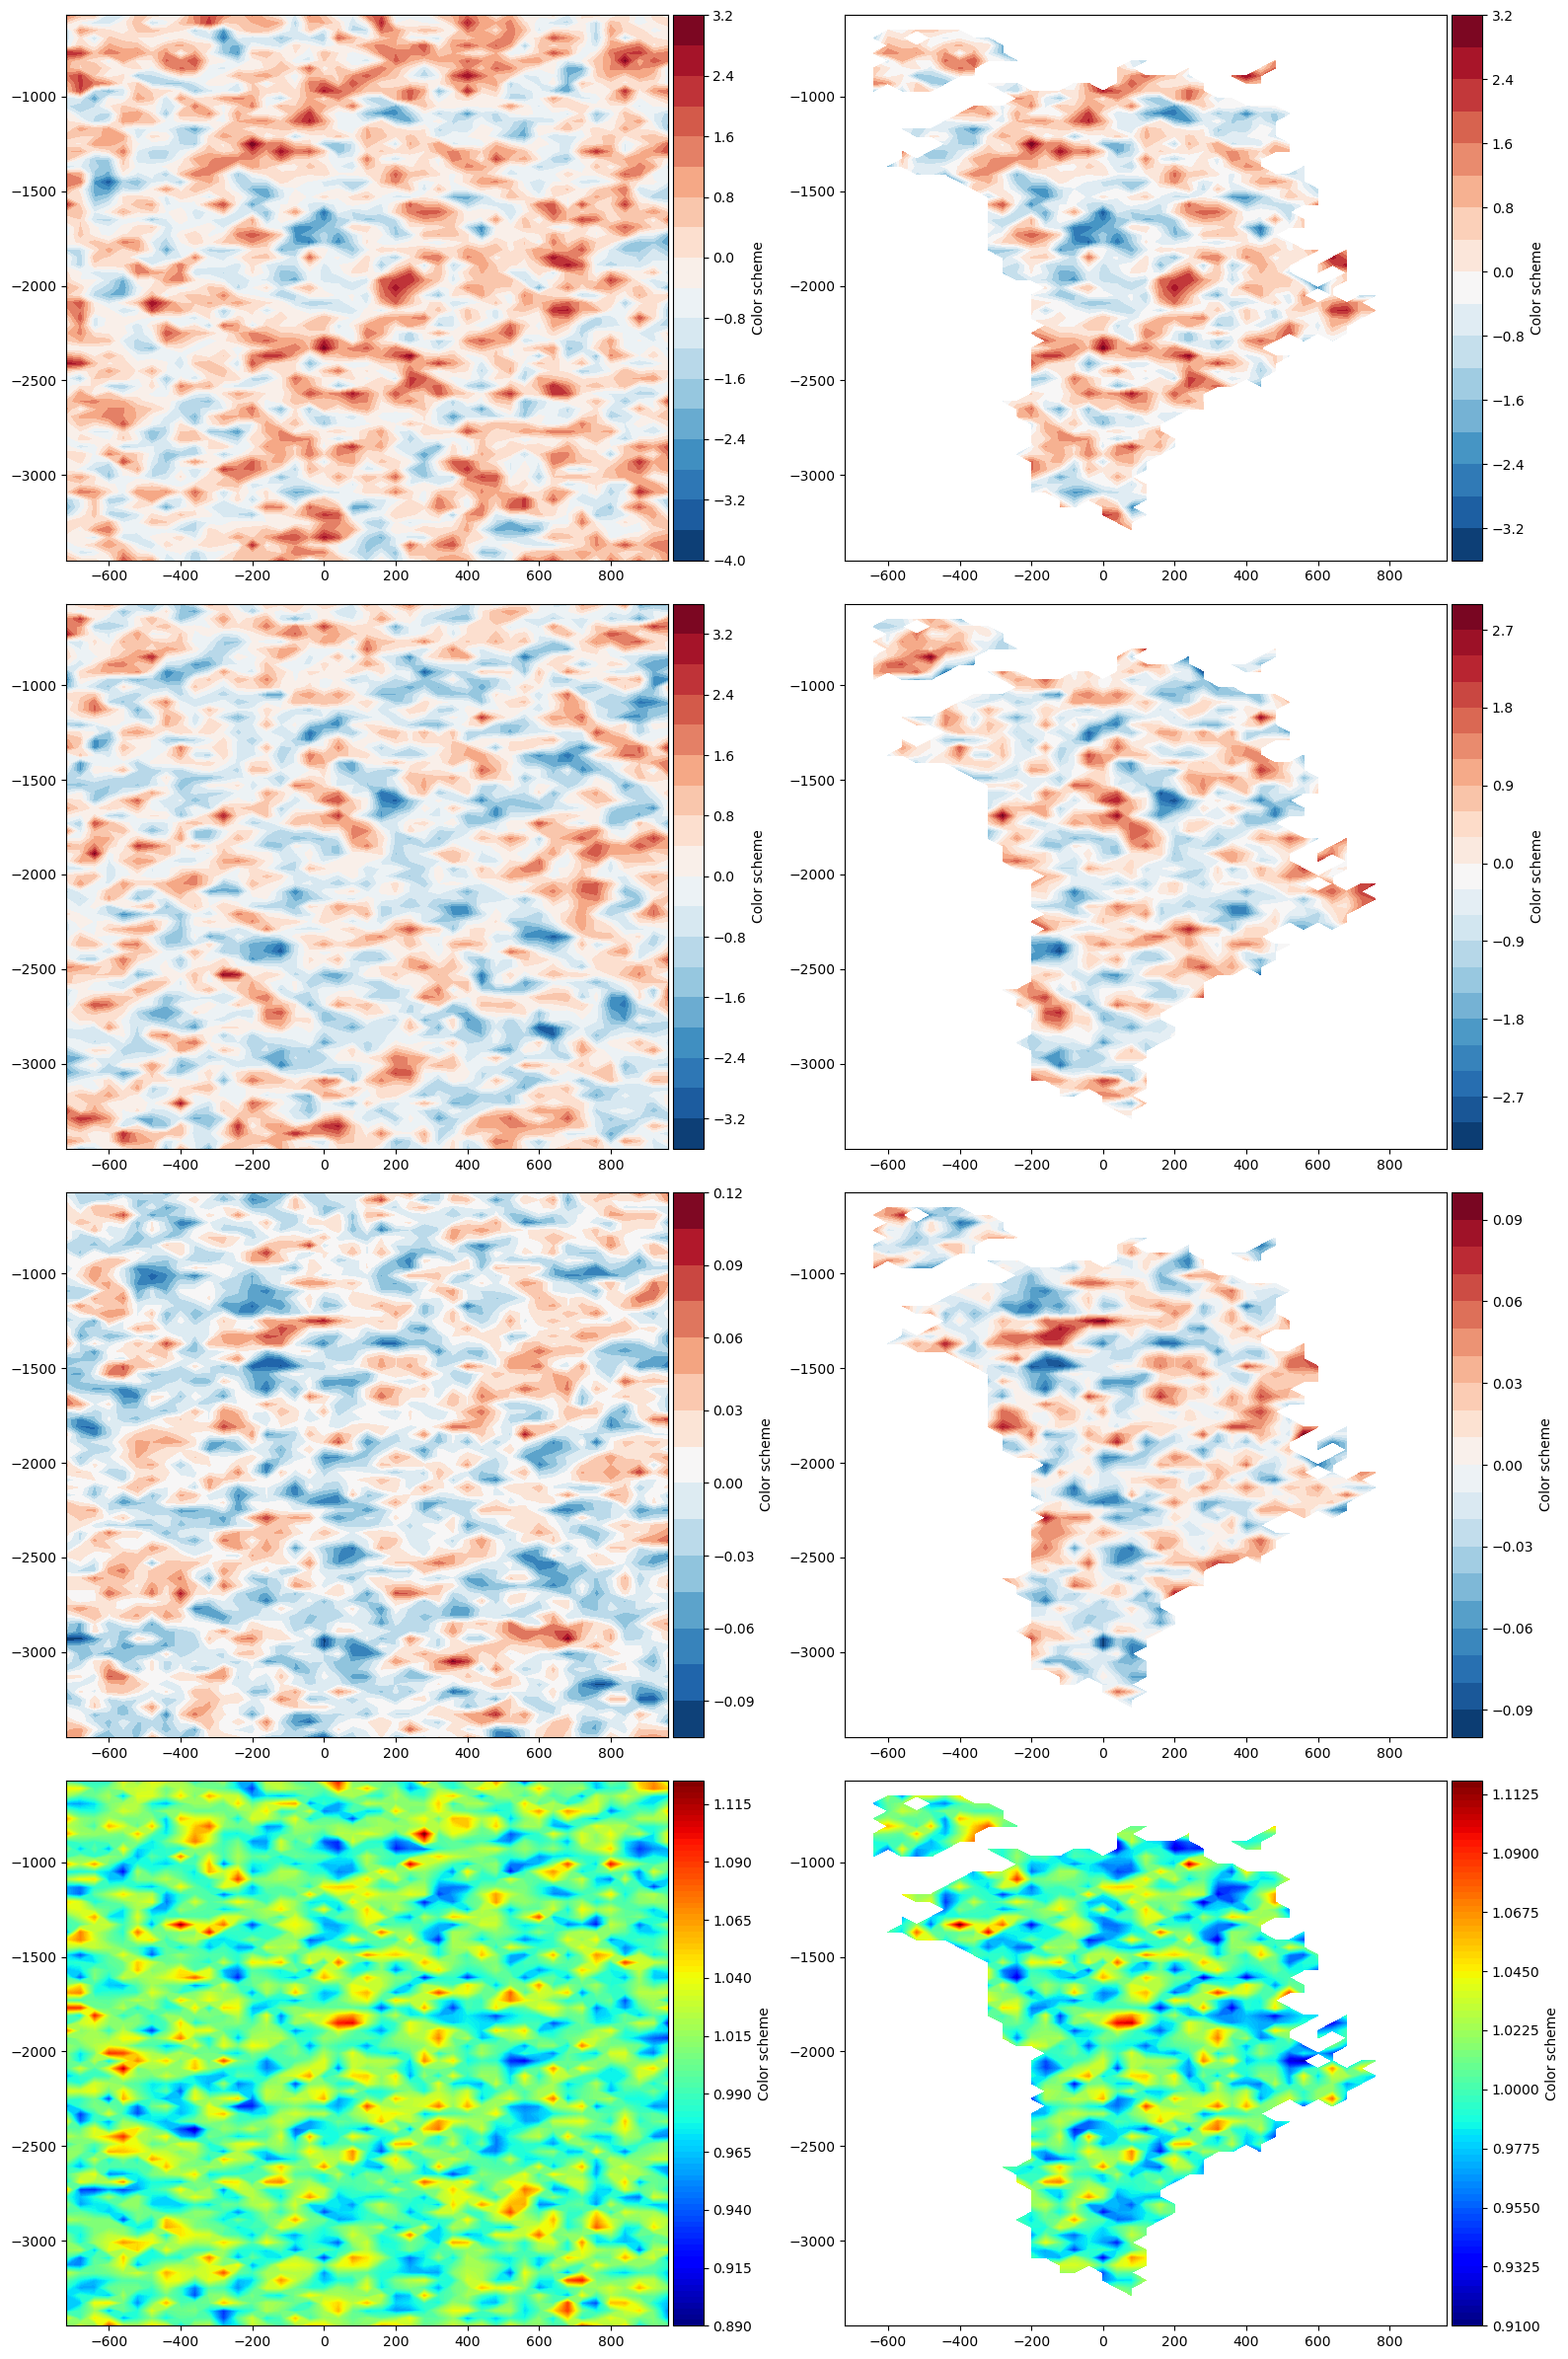

In [5]:
H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
fig, ax = plt.subplots(4, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [6]:
ds_x = DA.create_ad_tlm_action_input_nc(bool_randomize = True)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(1147915.8781911088, 1147915.8781825418)

In [7]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(1147915.8781911088, 1147915.8781825418)

In [8]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_A_SigmaXCx = DA.eval_tlm_action()
ds_noise_cov_inv_A_SigmaXCx = DA.eval_noise_cov_inv_action(ds_A_SigmaXCx)

dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)

ds_CT_XT_SigmaT_H_misfit_SigmaXCx = DA.eval_prior_preconditioned_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), DA.l2_inner_product([ds_A_SigmaXCx, ds_noise_cov_inv_A_SigmaXCx], ["tlmhessaction", "adjhessaction"])

(1013989.433230955, 1013989.433222942)

In [9]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_SigmaXC_inv_SigmaXCx = DA.eval_sqrt_prior_cov_inv_action()

DA.l2_inner_product([ds_SigmaXC_inv_SigmaXCx, ds_SigmaXC_inv_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

(3026.859854250375, 3026.8598542503755)

In [10]:
DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

(3100.823368437188, 3026.8598542503755)

In [11]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()

ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")

ds_SigmaXCx_as_adj_fields = xr.open_dataset(DA.dict_ad_inp_nc_files["tlm_action"])
ds_SigmaXCx_as_adj_fields = ds_SigmaXCx_as_adj_fields.rename({field + "d": field + "b" for field in dict_og_params_fields_vals})
for var in ds_SigmaXCx_as_adj_fields:
    if ds_SigmaXCx_as_adj_fields[var].attrs["type"] == "tlm":
        ds_SigmaXCx_as_adj_fields[var].attrs["type"] = "adj"
        if dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "2D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1))
        elif dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "3D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1)*(KCMAX+1))
ds_SigmaXCx_as_adj_fields.to_netcdf(DA.dict_ad_out_nc_files["adj_action"])

ds_CT_XT_SigmaT_SigmaXCx = DA.eval_sqrt_prior_covT_action(ad_key_adj_or_adj_action = "adj_action")

DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_SigmaXCx], ["tlm", "adj"])

(3100.823368437188, 3100.823368437188)

In [12]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_CT_XT_SigmaT_H_SigmaXCx = DA.eval_prior_preconditioned_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]) + DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_SigmaXCx], ["tlm", "adj"])

(1013989.433230955, 1017016.2930852054, 1017016.2930852055)

---------------------------------------------------------------------------------------------------------------
iter 0, fc = 124351.25048805274, fc_data = 124351.25048805274, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
Step size alpha = 0.001953125
---------------------------------------------------------------------------------------------------------------
iter 1, fc = 76987.89286342062, fc_data = 4163.211808454904, fc_reg = 72824.68105496572
---------------------------------------------------------------------------------------------------------------
Step size alpha = 0.25
---------------------------------------------------------------------------------------------------------------
iter 2, fc = 76487.7586283071, fc_data = 3865.725632803507, fc_reg = 72622.0329955036
---------------------------------------------------------------------------------------------------------------
Step size alpha = 0.01562

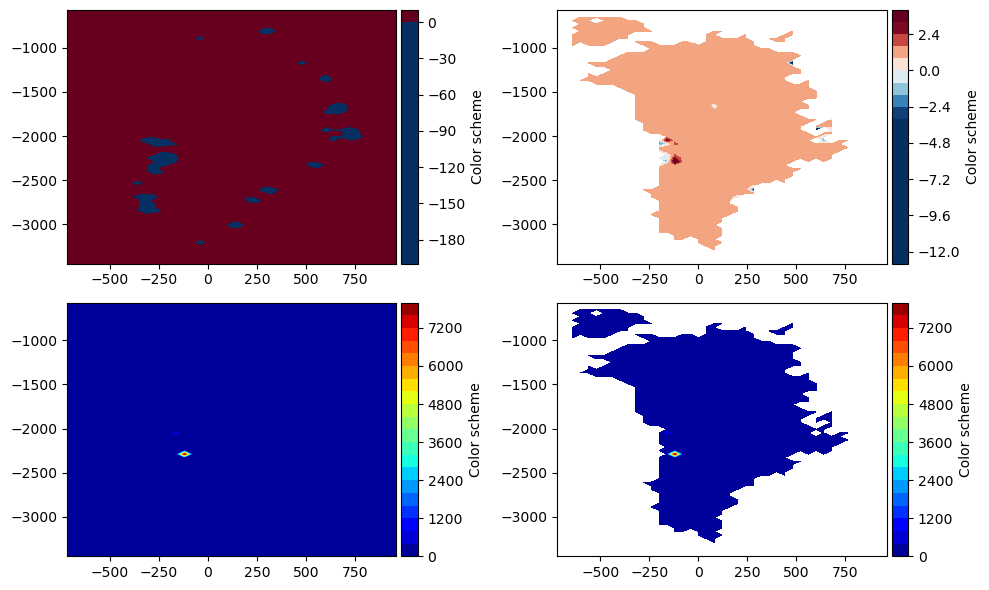

In [13]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir", None, ds_prior_X)

ds = DA.gradient_descent(5, init_alpha = 1.0, min_alpha_tol = 1.e-10)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (10,6)
fig, ax = plt.subplots(2, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -3, vmax = 3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -3, vmax = 3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data*mask,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
plt.tight_layout()

---------------------------------------------------------------------------------------------------------------
Initial fc = 124351.25048805274, fc_data = 124351.25048805274, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 85143.98030355977, norm_r_hat: 64436.70108858431
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  179.99999914622634
Step size alpha = 1.0
---------------------------------------------------------------------------------------------------------------
Outer iter 1, fc = 34136.77516833153, fc_data = 34136.10089146568, fc_reg = 0.6742768658492022
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 19889.54566426118, norm_r_hat: 15130.130812318328
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  180.0
Step size alpha = 1.0
-----------------

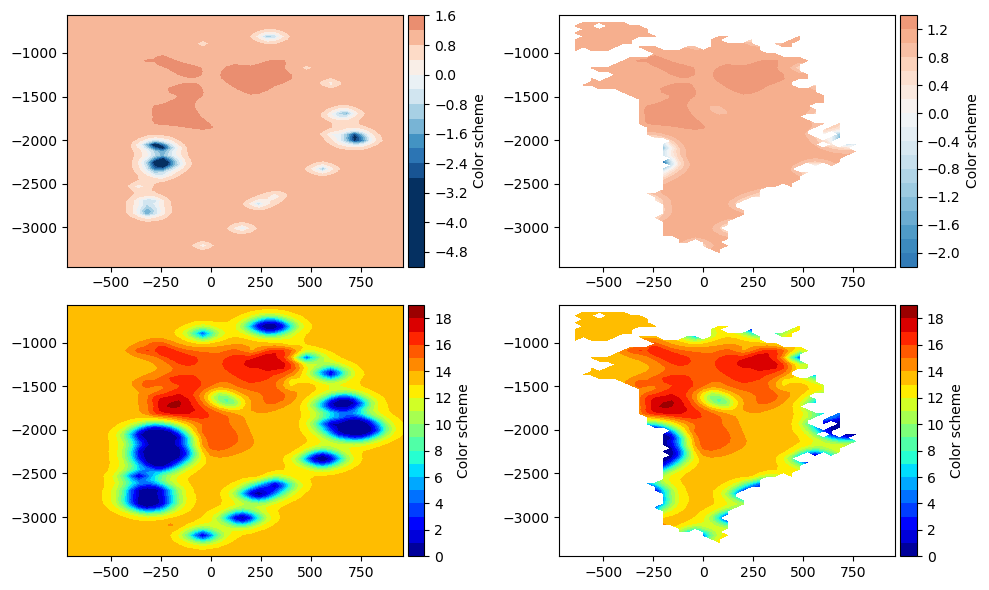

In [14]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir", None, ds_prior_X)

ds = DA.inexact_gn_hessian_cg(MAX_ITERS=5, init_alpha_gd = 1.e-6)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (10,6)
fig, ax = plt.subplots(2, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -3, vmax = 3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -3, vmax = 3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data*mask,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
plt.tight_layout()

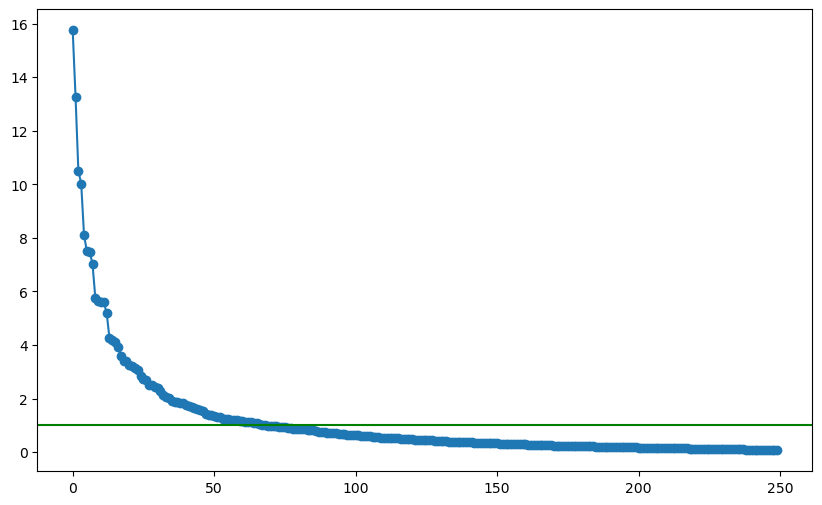

In [15]:
U_misfit, Lambda_misfit = DA.revd(245, 5, mode = "misfit_prior_precond")

plt.scatter(np.arange(Lambda_misfit.shape[0]), np.sort(Lambda_misfit)[::-1])
plt.plot(np.sort(Lambda_misfit)[::-1])

plt.axhline(1, color = "green")

In [16]:
np.sort(Lambda_misfit)[::-1]

array([15.75410039, 13.27964208, 10.50960557, 10.02958852,  8.11766658,
        7.49648024,  7.48893124,  7.02792521,  5.75231705,  5.63894633,
        5.59247   ,  5.58776398,  5.19995053,  4.24752956,  4.18922262,
        4.12468047,  3.9209225 ,  3.58827784,  3.40842548,  3.38384135,
        3.26255515,  3.21263075,  3.14958513,  3.04727369,  2.85345955,
        2.71938772,  2.70852566,  2.51198559,  2.50375078,  2.43191398,
        2.40101268,  2.2964068 ,  2.13981174,  2.05188379,  2.00075651,
        1.90166836,  1.86823372,  1.86713389,  1.84177624,  1.81830924,
        1.74107348,  1.71078932,  1.67716705,  1.65407972,  1.60272971,
        1.57145586,  1.53138471,  1.428099  ,  1.38504698,  1.37132609,
        1.35519705,  1.31449801,  1.29215048,  1.24947791,  1.24496654,
        1.23614884,  1.19543697,  1.19321187,  1.18118752,  1.17792489,
        1.17568538,  1.14044508,  1.13765162,  1.10493903,  1.0841997 ,
        1.07646607,  1.04016887,  1.02770849,  1.01979593,  0.98

In [17]:
sigma_B_squared, sigma_P_squared, delta_sigma_qoi_squared = DA.forward_uq_propagation(U_misfit, Lambda_misfit)
sigma_B_squared, sigma_P_squared, delta_sigma_qoi_squared

(1.6190449822852614e+19, 2.344122670859569e+18, 0.8552157168881824)

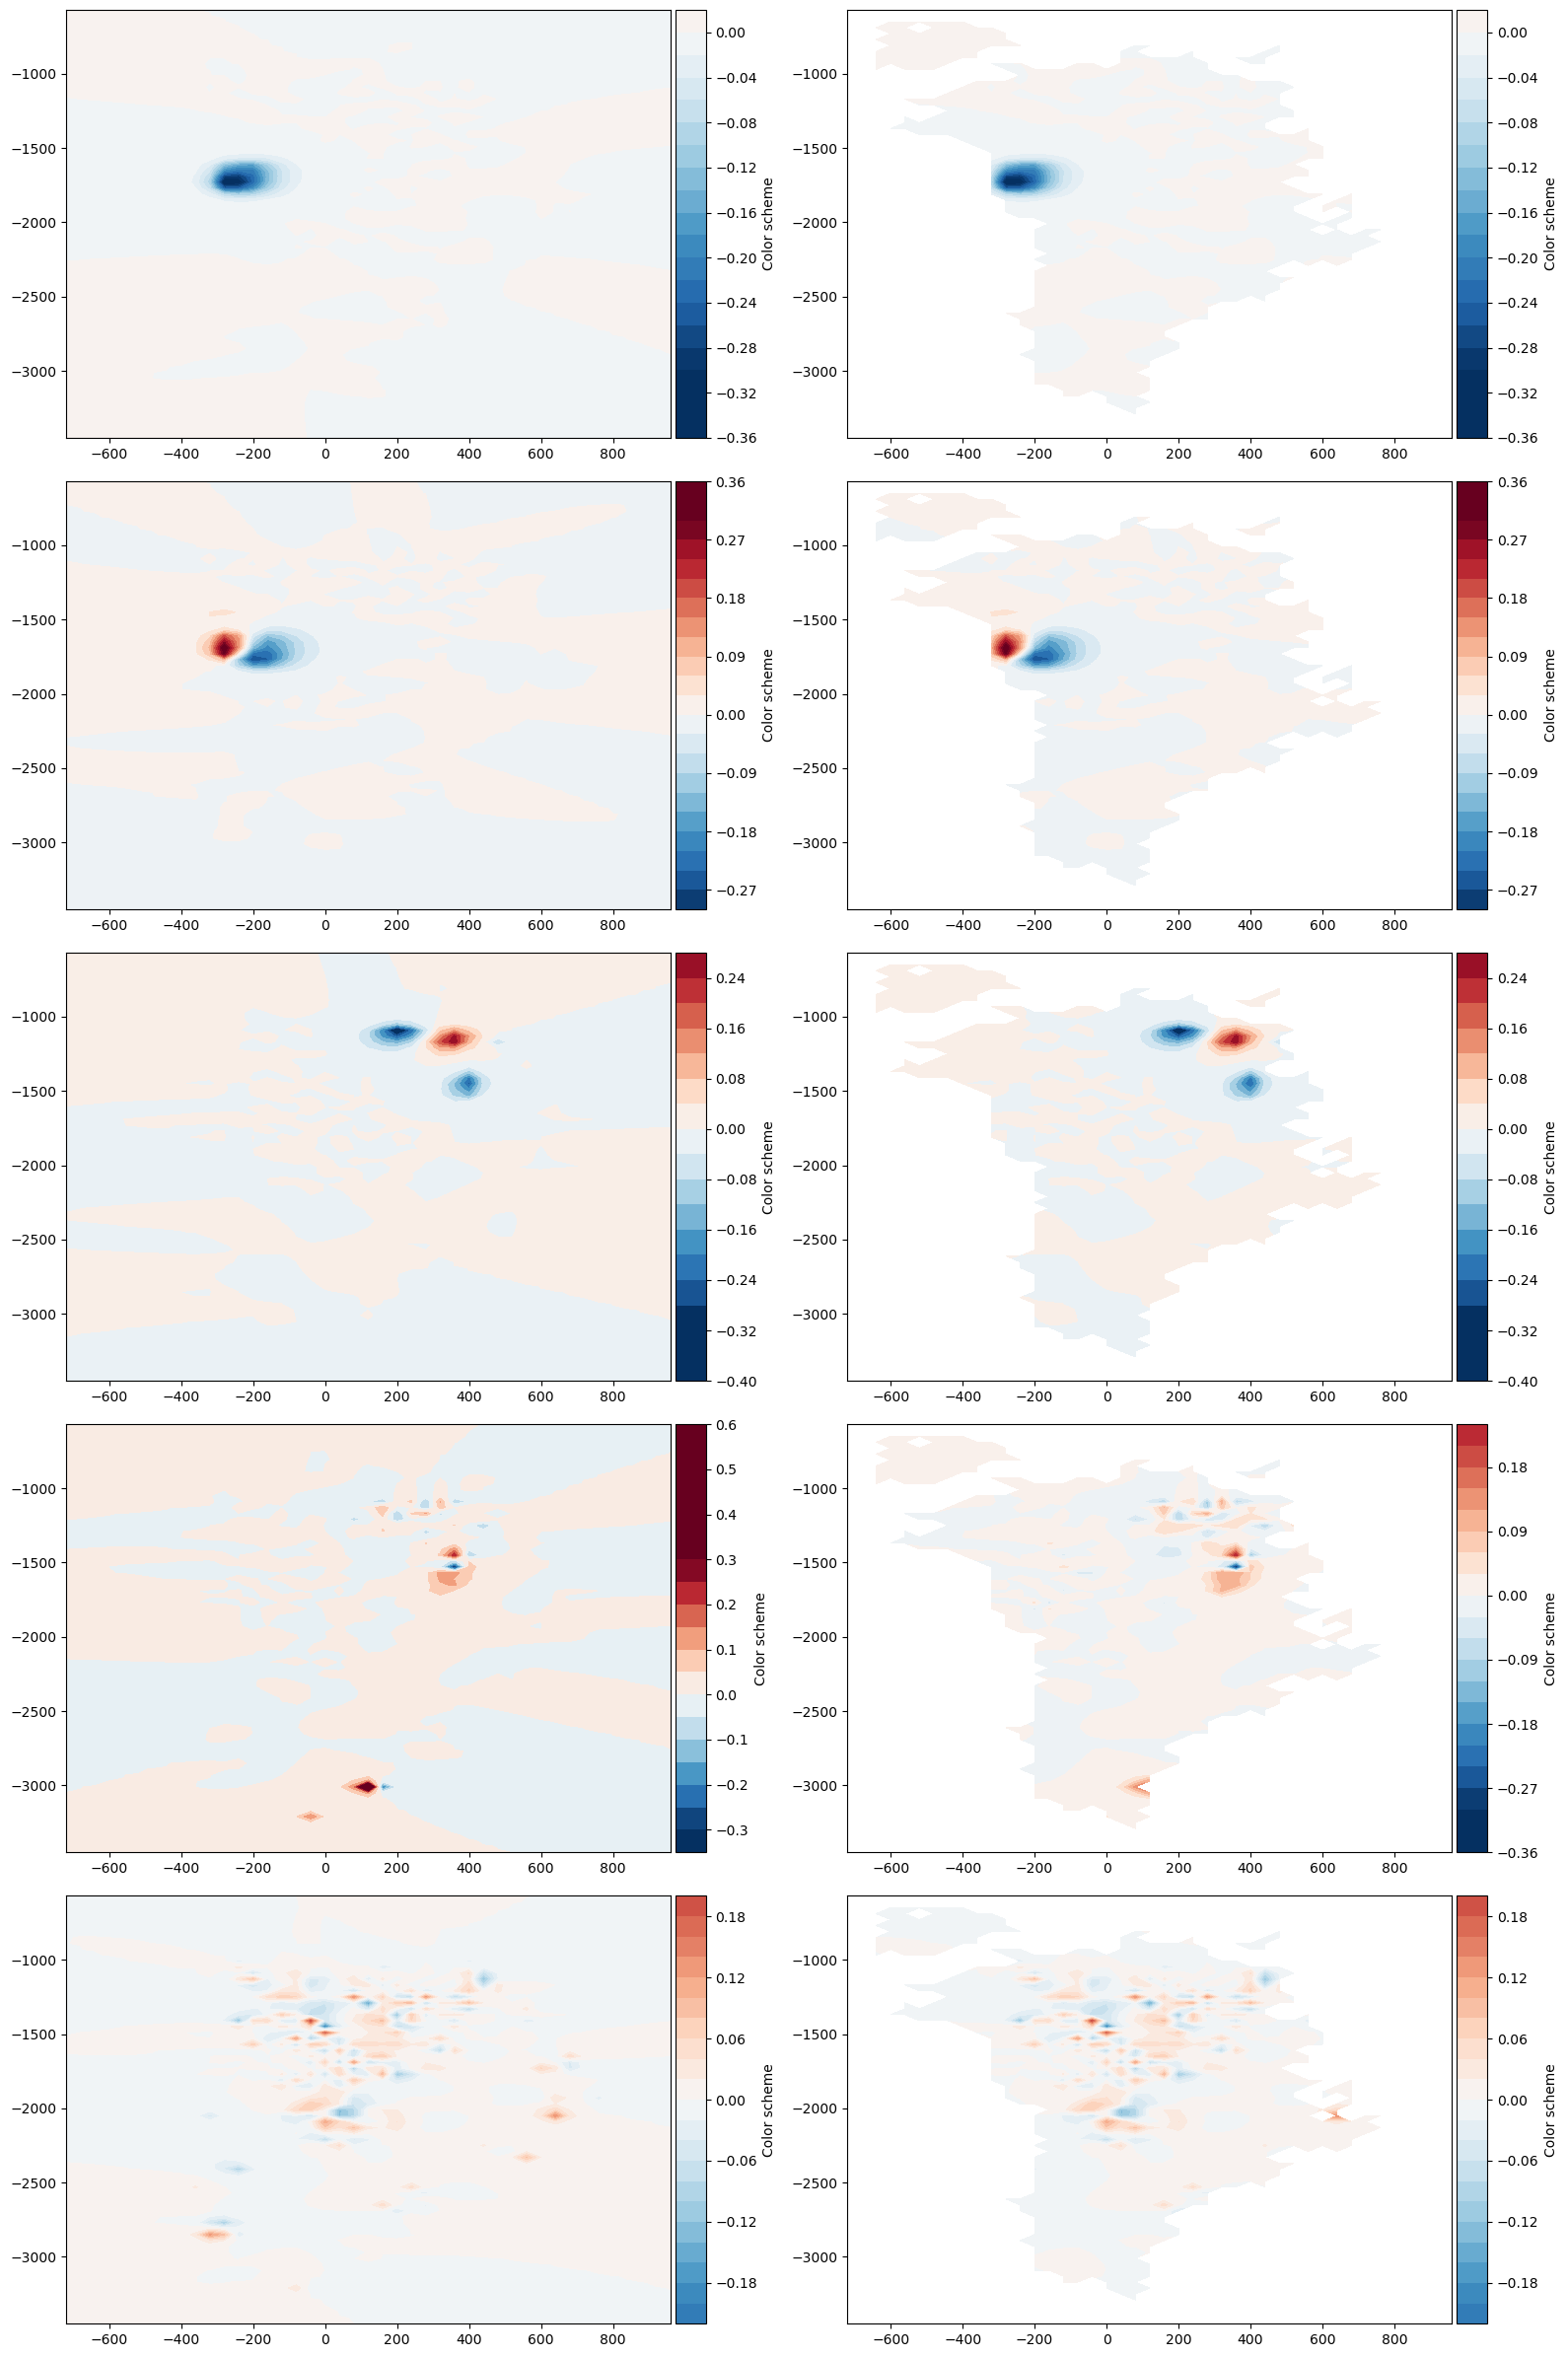

In [18]:
U_misfit_reshaped = np.reshape(U_misfit, (73, 43, -1))

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
fig, ax = plt.subplots(5, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 100],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 100]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[4, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[4, 1])
plt.tight_layout()

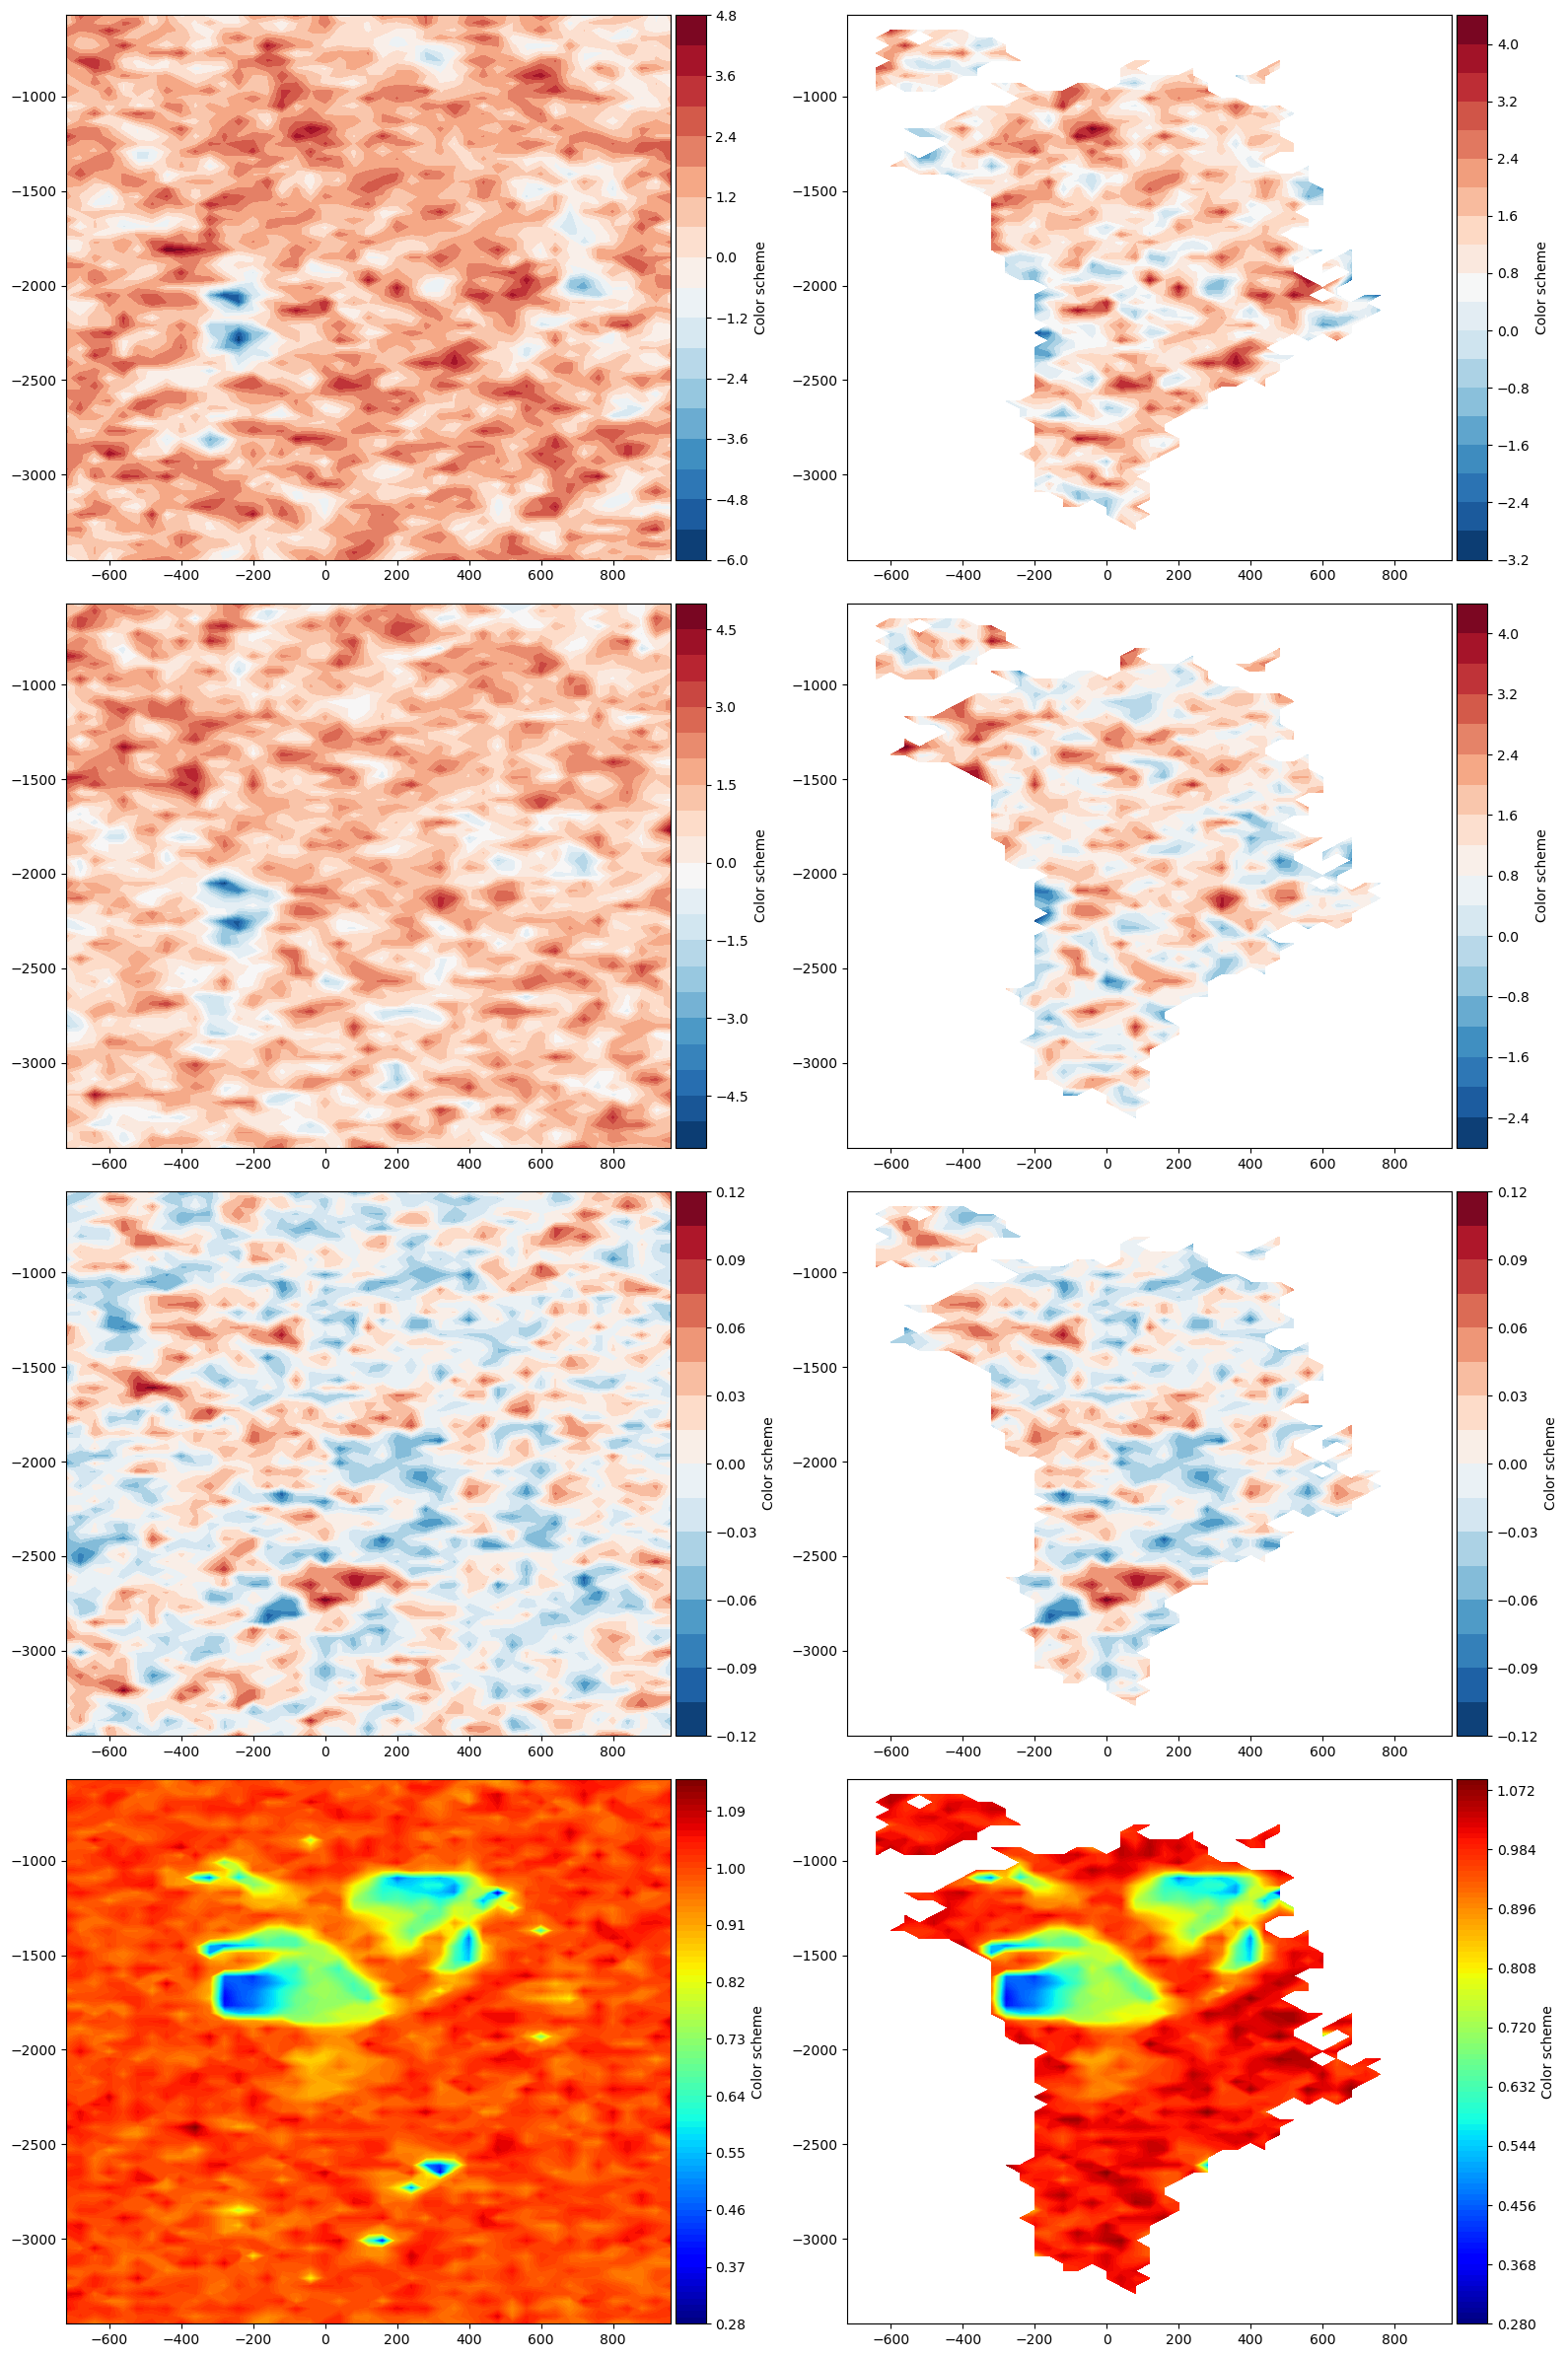

In [19]:
ds_subset_sample_posterior_1 = DA.sample_posterior(U_misfit, Lambda_misfit)
ds_subset_sample_posterior_2 = DA.sample_posterior(U_misfit, Lambda_misfit)
ds_mean_samples_posterior, ds_std_samples_posterior = DA.pointwise_marginals("posterior", 1000, U_misfit, Lambda_misfit)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
fig, ax = plt.subplots(4, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [20]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir", None, ds_prior_X)

DA.l_bfgs(5, 3)

---------------------------------------------------------------------------------------------------------------
Initial fc = 124351.25048805274, fc_data = 124351.25048805274, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
Step size alpha = 0.001953125
---------------------------------------------------------------------------------------------------------------
Iter 1, fc = 76987.89286342062, fc_data = 4163.211808454904, fc_reg = 72824.68105496572
---------------------------------------------------------------------------------------------------------------


FileNotFoundError: [Errno 2] No such file or directory: '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS/src/subroutines/tapenade/ad_io/ad_output_adj.nc'